# Intro

Here we use ALL perturbed cell-types.
This is done when we generate the pseudobulks by sampling from both perturbed or non-perturbed cells within each sample.

This data QCs the Kang et.al. data to make sure everything looks good.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.

This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Imports

In [1]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


In [38]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'sc_preprocessing.sc_preprocess' from '/beevol/home/davidson/checkouts/sc_bulk_ood/sc_preprocessing/2_make_pseudobulks/../../sc_preprocessing/sc_preprocess.py'>

# Parameters

In [3]:
# parameters

aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_kidney_data/"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_kidney/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/kidney_aging/"



#####################
### set the study ###
#####################

res_name = "all-kidney"
in_name = "kidney_droplet_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [4]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [5]:
# format metadata

def get_samp_id(in_str):
    out_str = "samp1"
    if in_str == "30-M-5":
        out_str = "samp2"
    elif in_str == "30-M-4":
        out_str = "samp3"
    elif in_str == "1-M-63":
        out_str = "samp4"
    elif in_str == "1-M-62":
        out_str = "samp5"

    return(out_str)

def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "30m":
        out_str = "CTRL"
           
    return(out_str)

adata.obs['CellType'] = adata.obs['names_merged'].tolist()
adata.obs['scpred_CellType'] = adata.obs['names_merged'].tolist()
adata.obs['sample_id'] = [get_samp_id(str(x)) for x in adata.obs['mouse.id'].tolist()]
adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs['age'].tolist()]

adata.var['gene_ids'] = adata.var.index.tolist()


In [6]:
np.where(adata.var['gene_ids'] == "Cd74")

(array([7282]),)

In [7]:
adata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,...,keep,names_merged,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType,sample_id,stim
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACTGGGT-1-1-1-0,30m,0,10X_P1_1_AAACCTGAGACTGGGT,epithelial cell of proximal tubule,CL:0002306,Epcam proximal tube epithelial cell,droplet,30-M-2,2349,male,...,yes,epithelial_proximal_tubule,2349,6487.507324,0.0,0.0,epithelial_proximal_tubule,epithelial_proximal_tubule,samp1,CTRL
AAACCTGAGATGTAAC-1-1-1-0,30m,0,10X_P1_1_AAACCTGAGATGTAAC,fibroblast,CL:0000057,Stroma fibroblast,droplet,30-M-2,1856,male,...,yes,fibroblast,1855,5875.506836,0.0,0.0,fibroblast,fibroblast,samp1,CTRL
AAACCTGAGGCTAGAC-1-1-1-0,30m,0,10X_P1_1_AAACCTGAGGCTAGAC,fibroblast,CL:0000057,Stroma fibroblast,droplet,30-M-2,1497,male,...,yes,fibroblast,1496,4930.554199,0.0,0.0,fibroblast,fibroblast,samp1,CTRL
AAACCTGGTAGAGCTG-1-1-1-0,30m,0,10X_P1_1_AAACCTGGTAGAGCTG,kidney distal convoluted tubule epithelial cell,CL:1000849,Epcam kidney distal convoluted tubule epit...,droplet,30-M-2,3055,male,...,yes,kidney_distal_convoluted_tubule_epithelial_cell,3055,7681.937988,0.0,0.0,kidney_distal_convoluted_tubule_epithelial_cell,kidney_distal_convoluted_tubule_epithelial_cell,samp1,CTRL
AAACCTGGTCATTAGC-1-1-1-0,30m,0,10X_P1_1_AAACCTGGTCATTAGC,podocyte,CL:0000653,Epcam podocyte,droplet,30-M-2,1226,male,...,yes,podocyte,1226,4573.443848,0.0,0.0,podocyte,podocyte,samp1,CTRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTATGCCATGCAATC-1-52-1-0,1m,0,10X_P5_9_TTTATGCCATGCAATC,kidney proximal convoluted tubule epithelial cell,CL:1000838,Epcam kidney proximal convoluted tubule epi...,droplet,1-M-63,1662,male,...,yes,kidney_proximal_convoluted_tubule_epithelial,1662,5794.836914,0.0,0.0,kidney_proximal_convoluted_tubule_epithelial,kidney_proximal_convoluted_tubule_epithelial,samp4,STIM
TTTATGCGTAAGTGTA-1-52-1-0,1m,0,10X_P5_9_TTTATGCGTAAGTGTA,kidney loop of Henle thick ascending limb epit...,CL:1001106,Epcam thick ascending tube S epithelial cell,droplet,1-M-63,1241,male,...,yes,kidney_loop_of_Henle_thick_ascending_limb_epit...,1241,5082.652344,0.0,0.0,kidney_loop_of_Henle_thick_ascending_limb_epit...,kidney_loop_of_Henle_thick_ascending_limb_epit...,samp4,STIM
TTTCCTCTCCAATGGT-1-52-1-0,1m,0,10X_P5_9_TTTCCTCTCCAATGGT,podocyte,CL:0000653,Epcam podocyte,droplet,1-M-63,4532,male,...,yes,podocyte,4531,9171.720703,0.0,0.0,podocyte,podocyte,samp4,STIM


### Preprocess

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


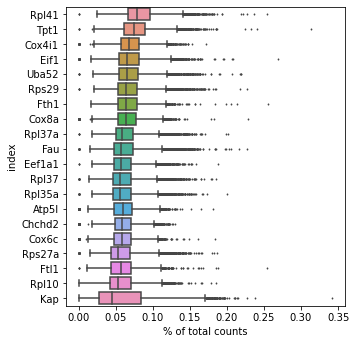

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


epithelial_proximal_tubule                                   2018
kidney_proximal_convoluted_tubule_epithelial                 1769
kidney_loop_of_Henle_thick_ascending_limb_epithelial_cell     795
macrophage                                                    573
kidney_collecting_duct_principal_cell                         448
fenestrated_capillary                                         436
podocyte                                                      263
T_NK_plasma                                                   232
kidney_distal_convoluted_tubule_epithelial_cell               212
kidney_cortex_artery_cell                                     190
lymphocyte                                                    117
fibroblast                                                     95
mesangial                                                      87
brush                                                          84
b_cell                                                         69
Name: scpr

In [10]:
# write out data for BP and cibersort
dense_matrix = adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())


pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


In [11]:
dense_matrix.shape

(7388, 16790)

# Plot Data

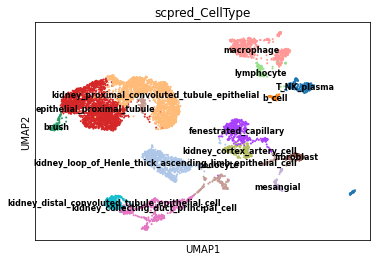

In [12]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

### First do some QC stats

In [13]:
adata.obs["sample_id"].value_counts()


samp3    2502
samp1    1734
samp5    1163
samp4    1054
samp2     935
Name: sample_id, dtype: int64

In [14]:
adata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,...,keep,names_merged,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType,sample_id,stim
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACTGGGT-1-1-1-0,30m,0,10X_P1_1_AAACCTGAGACTGGGT,epithelial cell of proximal tubule,CL:0002306,Epcam proximal tube epithelial cell,droplet,30-M-2,2349,male,...,yes,epithelial_proximal_tubule,2349,6487.507324,0.0,0.0,epithelial_proximal_tubule,epithelial_proximal_tubule,samp1,CTRL
AAACCTGAGATGTAAC-1-1-1-0,30m,0,10X_P1_1_AAACCTGAGATGTAAC,fibroblast,CL:0000057,Stroma fibroblast,droplet,30-M-2,1856,male,...,yes,fibroblast,1855,5875.506836,0.0,0.0,fibroblast,fibroblast,samp1,CTRL
AAACCTGAGGCTAGAC-1-1-1-0,30m,0,10X_P1_1_AAACCTGAGGCTAGAC,fibroblast,CL:0000057,Stroma fibroblast,droplet,30-M-2,1497,male,...,yes,fibroblast,1496,4930.554199,0.0,0.0,fibroblast,fibroblast,samp1,CTRL
AAACCTGGTAGAGCTG-1-1-1-0,30m,0,10X_P1_1_AAACCTGGTAGAGCTG,kidney distal convoluted tubule epithelial cell,CL:1000849,Epcam kidney distal convoluted tubule epit...,droplet,30-M-2,3055,male,...,yes,kidney_distal_convoluted_tubule_epithelial_cell,3055,7681.937988,0.0,0.0,kidney_distal_convoluted_tubule_epithelial_cell,kidney_distal_convoluted_tubule_epithelial_cell,samp1,CTRL
AAACCTGGTCATTAGC-1-1-1-0,30m,0,10X_P1_1_AAACCTGGTCATTAGC,podocyte,CL:0000653,Epcam podocyte,droplet,30-M-2,1226,male,...,yes,podocyte,1226,4573.443848,0.0,0.0,podocyte,podocyte,samp1,CTRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTATGCCATGCAATC-1-52-1-0,1m,0,10X_P5_9_TTTATGCCATGCAATC,kidney proximal convoluted tubule epithelial cell,CL:1000838,Epcam kidney proximal convoluted tubule epi...,droplet,1-M-63,1662,male,...,yes,kidney_proximal_convoluted_tubule_epithelial,1662,5794.836914,0.0,0.0,kidney_proximal_convoluted_tubule_epithelial,kidney_proximal_convoluted_tubule_epithelial,samp4,STIM
TTTATGCGTAAGTGTA-1-52-1-0,1m,0,10X_P5_9_TTTATGCGTAAGTGTA,kidney loop of Henle thick ascending limb epit...,CL:1001106,Epcam thick ascending tube S epithelial cell,droplet,1-M-63,1241,male,...,yes,kidney_loop_of_Henle_thick_ascending_limb_epit...,1241,5082.652344,0.0,0.0,kidney_loop_of_Henle_thick_ascending_limb_epit...,kidney_loop_of_Henle_thick_ascending_limb_epit...,samp4,STIM
TTTCCTCTCCAATGGT-1-52-1-0,1m,0,10X_P5_9_TTTCCTCTCCAATGGT,podocyte,CL:0000653,Epcam podocyte,droplet,1-M-63,4532,male,...,yes,podocyte,4531,9171.720703,0.0,0.0,podocyte,podocyte,samp4,STIM


In [15]:
adata.obs["scpred_CellType"].unique()

['epithelial_proximal_tubule', 'fibroblast', 'kidney_distal_convoluted_tubule_epithelial_cell', 'podocyte', 'T_NK_plasma', ..., 'macrophage', 'kidney_cortex_artery_cell', 'brush', 'b_cell', 'mesangial']
Length: 15
Categories (15, object): ['T_NK_plasma', 'b_cell', 'brush', 'epithelial_proximal_tubule', ..., 'lymphocyte', 'macrophage', 'mesangial', 'podocyte']

### now split test and train cells

In [16]:
# generate cell-type specific split
adata.obs["isTraining"] = "Train"


stim_idx = np.where(adata.obs.stim == "STIM")[0]
adata.obs["isTraining"][stim_idx] = "Test"


<ipython-input-16-6097bf4a867b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["isTraining"][stim_idx] = "Test"


In [17]:
pd.set_option('display.max_rows', 160)

tab = adata.obs.groupby(['stim', 'isTraining']).size()

tab.unstack()

isTraining,Test,Train
stim,,
CTRL,0,5171
STIM,2217,0


In [18]:
tab = adata.obs.groupby(['isTraining', 'sample_id']).size()

tab.unstack()

sample_id,samp1,samp2,samp3,samp4,samp5
isTraining,,,,,
Test,0,0,0,1054,1163
Train,1734,935,2502,0,0


In [19]:
tab = adata.obs.groupby(['isTraining', 'age']).size()

tab.unstack()

age,1m,30m
isTraining,,
Test,2217,0
Train,0,5171


## Make pseudobulks

In [20]:
a = [0,1,3,4]
len(np.where(a == 2)[0])

0

In [39]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
sample_order = ['samp1', 'samp2', 'samp3', 'samp4', 'samp5']
stim_order = ['STIM', 'CTRL']
train_order = ['Train', 'Test']

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 5000
idx = 0
for curr_samp in sample_order:
  for curr_stim in stim_order:
      for curr_train in train_order:

        print(f"running {curr_samp} {curr_stim} {curr_train}")


        # make the pseudobulks
        subset_idx = np.where(np.logical_and(adata.obs.sample_id == curr_samp, adata.obs.stim == curr_stim))[0]
        if len(subset_idx) == 0:
            continue
        
        temp_adata = adata[subset_idx]

        print("make_prop_and_sum")
        prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(temp_adata, 
                                                                                num_samples=1000, 
                                                                                num_cells=num_cells,
                                                                                use_true_prop=False,
                                                                                cell_noise=cell_noise,
                                                                                useSampleNoise=False)

        # get the single cell type proportions
        print("get_single_celltype_prop_matrix")
        ct_prop_df = sc_preprocess.get_single_celltype_prop_matrix(num_samp=100,
                                                                    cell_order=cell_order)

        # now get the cell-type specific pseudobulks
        print("use_prop_make_sum")
        prop_df_sc, pseudobulks_df_sc, _ = sc_preprocess.use_prop_make_sum(temp_adata,  
                                                                            num_cells=num_cells, 
                                                                            props_vec=ct_prop_df, 
                                                                            cell_noise=cell_noise,
                                                                            sample_noise=None,
                                                                            useSampleNoise=False)

        # put them together
        print("concat")        
        prop_df = pd.concat([prop_df,prop_df_sc])
        pseudobulks_df = pd.concat([pseudobulks_df, pseudobulks_df_sc])

        # make the proportions instead of cell counts
        prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
        pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
        prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_prop_splits.pkl")

        print("write")        
        pseudobulk_path = Path(pseudobulk_file)
        prop_path = Path(prop_file)
        pickle.dump( prop_df, open( prop_path, "wb" ) )
        pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )





running samp1 STIM Train
running samp1 STIM Test
running samp1 CTRL Train
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
concat
write
running samp1 CTRL Test
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400


In [26]:
np.random.lognormal(0, 0, 10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])